# Import libraries

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset

In [51]:
df = pd.read_csv("C:/Users/98939/Downloads/MASTER_DATASET.csv")  
print("Shape of dataset:", df.shape)
df.head()

Shape of dataset: (100000, 43)


,Timestamp,Time,Pressure_In,Temperature_In,Flow_Rate,Pressure_Out,Temperature_Out,Efficiency,Power_Consumption,Vibration,...,Velocity,Viscosity,Phase_Angle,vib_min,vib_rms,Pressure_In_Filtered,Temperature_In_Filtered,Label,Flow_Rate_Filtered,Vibration_Filtered
0,2025-01-01 00:00:00,0,3.524836,25.880595,12.156184,17.436829,203.077815,0.813001,5803.345268,1.151771,...,30.063063,0.00001,183.382071,0.523325,1.151771,3.524836,25.880595,1.0,12.156184,1.151771
1,2025-01-01 00:00:01,1,3.503083,23.692395,12.010572,17.406759,197.494853,0.823139,5554.713072,1.010584,...,31.895808,0.00001,183.198709,0.523325,1.010584,3.511784,24.567675,0.0,12.068817,1.067059
2,2025-01-01 00:00:02,2,3.552351,25.416440,11.907004,17.954038,203.341908,0.820196,5657.678081,0.949326,...,31.005970,0.00001,183.712548,0.523325,0.949326,3.536748,25.089992,0.0,11.969240,0.994608
3,2025-01-01 00:00:03,3,3.606039,24.210525,11.920992,18.213320,201.438404,0.819783,5644.959322,1.079461,...,30.242627,0.00001,180.863281,0.523325,1.079461,3.579546,24.546792,0.0,11.939440,1.047017
4,2025-01-01 00:00:04,4,3.528026,24.486640,12.045394,17.854835,200.631142,0.825436,5630.174826,1.068124,...,29.277585,0.00001,184.095677,0.523325,1.068124,3.547708,24.509620,0.0,12.004917,1.060061


# Selecting Relevant Features for RTO

In [52]:
# Drop irrelevant or anomaly-detection-related columns
drop_cols = [
    'Timestamp', 'Time', 'Anomaly_IForest', 'Anomaly_LOF', 'Anomaly_DBSCAN',
    'Anomaly_Autoencoder', 'Anomaly_Score', 'Final_Anomaly', 'Label'
]

# Define your target variable (choose based on your focus)
target_variable = 'Efficiency'

# Remaining relevant features (auto-filtered)
rto_df = df.drop(columns=drop_cols)

# Drop rows with missing values (if any)
rto_df = rto_df.dropna()

# Show updated shape and columns
print(f"Cleaned RTO dataframe shape: {rto_df.shape}")
rto_df.columns

Cleaned RTO dataframe shape: (99961, 34)


Index(['Pressure_In', 'Temperature_In', 'Flow_Rate', 'Pressure_Out',
       'Temperature_Out', 'Efficiency', 'Power_Consumption', 'Vibration',
       'Status', 'Ambient_Temperature', 'Humidity', 'Air_Pollution',
       'Startup_Shutdown_Cycles', 'Maintenance_Quality', 'Fuel_Quality',
       'Load_Factor', 'Stiffness', 'Frequency', 'Damping', 'Mass', 'vib_std',
       'vib_max', 'Amplitude', 'Density', 'vib_mean', 'Velocity', 'Viscosity',
       'Phase_Angle', 'vib_min', 'vib_rms', 'Pressure_In_Filtered',
       'Temperature_In_Filtered', 'Flow_Rate_Filtered', 'Vibration_Filtered'],
      dtype='object')

# Correlation Check

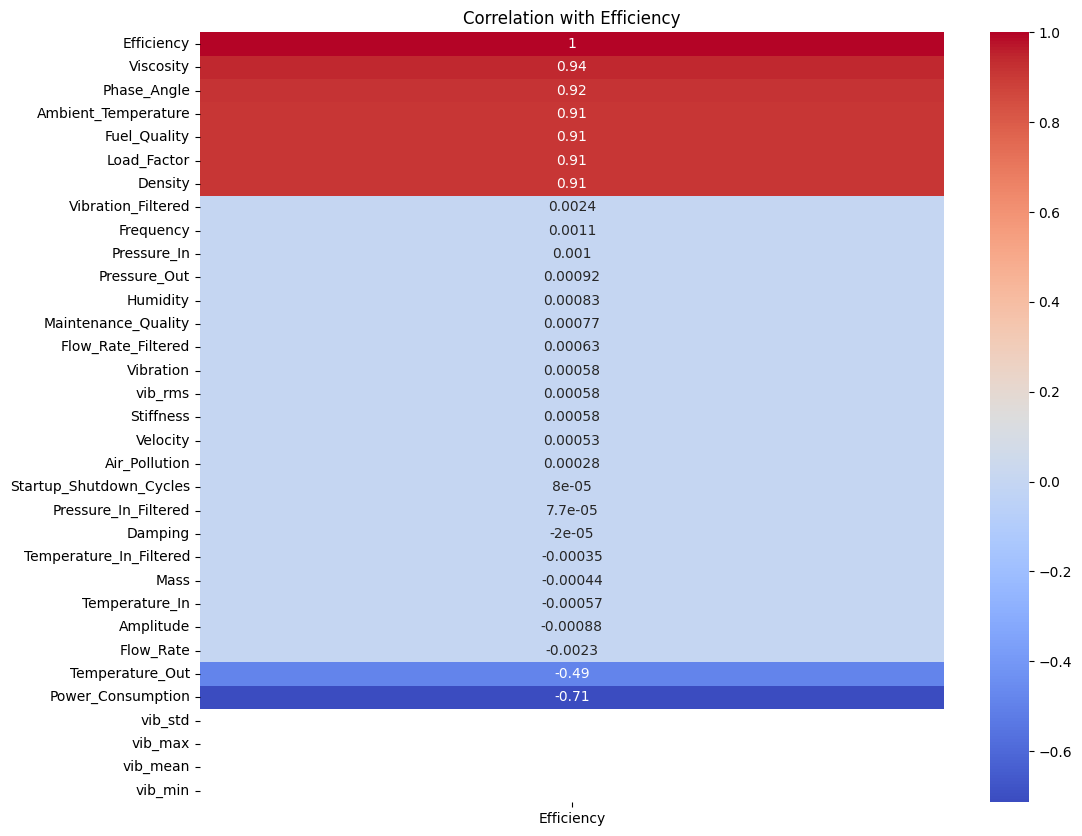

In [53]:
# Correlation matrix
numeric_df = rto_df.select_dtypes(include='number')

plt.figure(figsize=(12, 10))
corr = numeric_df.corr()[[target_variable]].sort_values(by=target_variable, ascending=False)
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title(f'Correlation with {target_variable}')
plt.show()

# Statistical profiling of real sensor ranges

In [54]:
# Let's define numerical features relevant to sensor readings
sensor_columns = [
    'Pressure_In', 'Temperature_In', 'Flow_Rate', 'Pressure_Out', 
    'Temperature_Out', 'Vibration', 'Ambient_Temperature', 'Humidity'
]

# Show basic statistics
sensor_stats = df[sensor_columns].describe().T
sensor_stats[['min', 'mean', 'std', '25%', '50%', '75%', 'max']]


,min,mean,std,25%,50%,75%,max
Pressure_In,3.103911,3.500083,0.149954,3.367158,3.500198,3.633266,3.885274
Temperature_In,11.565104,19.851396,3.674704,16.469988,19.856294,23.230476,28.675928
Flow_Rate,11.130454,12.000067,0.367424,11.662399,12.000636,12.337798,12.835353
Pressure_Out,14.702065,17.520087,1.239818,16.359607,17.499735,18.674995,20.647857
Temperature_Out,167.117590,193.101229,8.061821,187.559640,194.882853,199.448647,211.862818
Vibration,0.523325,0.999698,0.217959,0.794291,1.000075,1.204116,1.505208
Ambient_Temperature,16.255462,25.006518,3.676794,21.624763,25.015375,28.395021,34.274941
Humidity,32.254264,50.010321,7.358204,43.244448,50.017302,56.774270,67.646258


# Define normal operating range using percentiles

In [55]:
# Create a DataFrame to hold limits
normal_ranges = pd.DataFrame(index=sensor_columns, columns=['lower', 'upper'])

for col in sensor_columns:
    lower = df[col].quantile(0.05)
    upper = df[col].quantile(0.95)
    normal_ranges.loc[col] = [lower, upper]

normal_ranges


,lower,upper
Pressure_In,3.273689,3.726374
Temperature_In,14.420218,25.302496
Flow_Rate,11.456246,12.544016
Pressure_Out,15.721742,19.363339
Temperature_Out,177.686276,203.617132
Vibration,0.681146,1.318489
Ambient_Temperature,19.553522,30.447234
Humidity,39.118962,60.890313


# Filter data points within normal operating ranges

In [56]:
# Start with all True mask
within_constraints_mask = pd.Series(True, index=df.index)

for col in sensor_columns:
    lower = normal_ranges.loc[col, 'lower']
    upper = normal_ranges.loc[col, 'upper']
    within_constraints_mask &= (df[col] >= lower) & (df[col] <= upper)

# Filtered DataFrame
df_within_constraints = df[within_constraints_mask]

print("Number of data points within new realistic constraints:", len(df_within_constraints))


Number of data points within new realistic constraints: 45871


In [ ]:
# Plot 

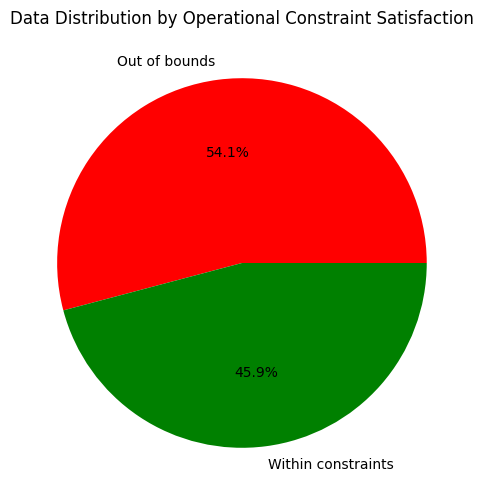

In [57]:
import matplotlib.pyplot as plt

# Count of data points within and outside constraints
within_count = len(df_within_constraints)
outside_count = len(df) - within_count

# Create a series for plotting
distribution = pd.Series([outside_count, within_count], index=["Out of bounds", "Within constraints"])

# Plot pie chart
plt.figure(figsize=(6, 6))
distribution.plot(kind='pie', autopct='%1.1f%%', colors=["red", "green"])
plt.title("Data Distribution by Operational Constraint Satisfaction")
plt.ylabel("")  # Hide y-label for cleaner plot
plt.show()


# RL (PPO)

##  Define custom RL environment for compressor control

In [58]:
!pip install gym


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [59]:
import gym
from gym import spaces
import numpy as np

class CompressorEnv(gym.Env):
    """
    Custom RL environment for dynamic compressor parameter adjustment.
    State: sensor readings (pressure, temperature, flow rate, vibration)
    Action: adjustment of control parameters (e.g., efficiency setting)
    Reward: negative power consumption (to minimize it) + penalty if vibration above threshold
    """
    def __init__(self, data, vibration_threshold=0.5):
        super(CompressorEnv, self).__init__()
        
        self.data = data.reset_index(drop=True)
        self.vibration_threshold = vibration_threshold
        
        # Define action space: let's say continuous adjustment [-1, 1] for one parameter (for simplicity)
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        
        # Define observation space: sensor features (normalized)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(4,), dtype=np.float32)
        
        self.current_step = 0

    def reset(self):
        self.current_step = 0
        return self._get_obs()
    
    def _get_obs(self):
        # Select relevant sensors at current step: Pressure_In, Temperature_In, Flow_Rate, Vibration
        state = self.data.loc[self.current_step, ['Pressure_In', 'Temperature_In', 'Flow_Rate', 'Vibration']].values.astype(np.float32)
        return state

    def step(self, action):
        done = False
        
        # Simulate effect of action (simplified): 
        # Let's say action adjusts Efficiency in range [0.9, 1.1]
        efficiency_adjustment = 1 + 0.1 * action[0]
        
        # Calculate reward: negative power consumption times efficiency adjustment (we want to minimize power)
        power = self.data.loc[self.current_step, 'Power_Consumption']
        vibration = self.data.loc[self.current_step, 'Vibration']
        
        reward = -power * efficiency_adjustment
        
        # Add penalty if vibration above threshold
        if vibration > self.vibration_threshold:
            reward -= 10.0
        
        self.current_step += 1
        if self.current_step >= len(self.data) - 1:
            done = True
        
        obs = self._get_obs() if not done else np.zeros_like(self._get_obs())
        
        return obs, reward, done, {}


## Train PPO agent on compressor environment

In [60]:
!pip install stable-baselines3


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [69]:
from stable_baselines3 import PPO

# Filter dataset to only rows within operational constraints 
df_within_constraints = df[(df['Vibration'] <= 0.5)]  

env = CompressorEnv(df_within_constraints, vibration_threshold=0.5)

model = PPO("MlpPolicy", env, verbose=1)

# Train for 10000 steps 
model.learn(total_timesteps=10000)


ModuleNotFoundError: No module named 'stable_baselines3'

## Evaluate trained agent performance

In [ ]:
obs = env.reset()
done = False
rewards = []
actions = []

while not done:
    action, _states = model.predict(obs)
    obs, reward, done, info = env.step(action)
    rewards.append(reward)
    actions.append(action)

print(f"Total reward collected by agent: {sum(rewards)}")

import matplotlib.pyplot as plt
plt.plot(rewards)
plt.title('Reward Over Time')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.show()


# MPC

Simple MPC Implementation for Compressor Vibration Minimization

## Libraries

Load and preprocess data (assuming df is your filtered DataFrame within constraints)
Use relevant features as inputs and vibration as output

In [70]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from scipy.optimize import minimize

## Features selected based on domain knowledge and correlation analysis

In [71]:
features = ['Pressure_In', 'Temperature_In', 'Flow_Rate', 'Efficiency']
target = 'Vibration'

X = df[features]
y = df[target]

## Train a regression model to predict vibration

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

## Define the MPC objective function: predicted vibration by the model

In [ ]:
def mpc_objective(x):
    """
    Predict vibration given compressor parameters.
    x: array of inputs [Pressure_In, Temperature_In, Flow_Rate, Efficiency]
    Returns predicted vibration to be minimized.
    """
    x_reshaped = np.array(x).reshape(1, -1)
    pred_vib = model.predict(x_reshaped)[0]
    return pred_vib

## Define realistic bounds for the control variables based on data statistics

In [ ]:
bounds = [
    (df['Pressure_In'].min(), df['Pressure_In'].max()),
    (df['Temperature_In'].min(), df['Temperature_In'].max()),
    (df['Flow_Rate'].min(), df['Flow_Rate'].max()),
    (df['Efficiency'].min(), df['Efficiency'].max())
]

## Initial guess for the optimizer (mean values)

In [ ]:
x0 = [
    df['Pressure_In'].mean(),
    df['Temperature_In'].mean(),
    df['Flow_Rate'].mean(),
    df['Efficiency'].mean()
]

## Run the optimizer to find input parameters minimizing vibration

In [ ]:
result = minimize(mpc_objective, x0, bounds=bounds, method='L-BFGS-B')

# Step 7: Output the optimal parameters and predicted vibration
print("Optimal parameters found by MPC:")
for feat, val in zip(features, result.x):
    print(f"{feat}: {val:.3f}")

print(f"Predicted minimum vibration: {result.fun:.4f}")